In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.lines as mlines


In [2]:
import numpy as np
import pandas as pd

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


from sqlalchemy import and_
from sqlalchemy import distinct


In [4]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
# Calculate the date 1 year ago from the last ever date on the dataset
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

last_date


('2017-08-23')

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results


#Query date is calculated as one year  from the last date on the dataset we found above
query_date =  '2016-08-23'

# Perform a query to retrieve the all the data and precipitation scores of past 12 months beginning from the query_date
Last12_prcp = session.query(Measurement.prcp, Measurement.date).filter(Measurement.date >= query_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
Prcp_df = pd.DataFrame(Last12_prcp)
Prcp_df = Prcp_df.set_index('date')

# Sort the dataframe by date
Prcp_df = Prcp_df.sort_values(by=['date']).dropna()
Prcp_df.columns = ['Precipitation']




<IPython.core.display.Javascript object>


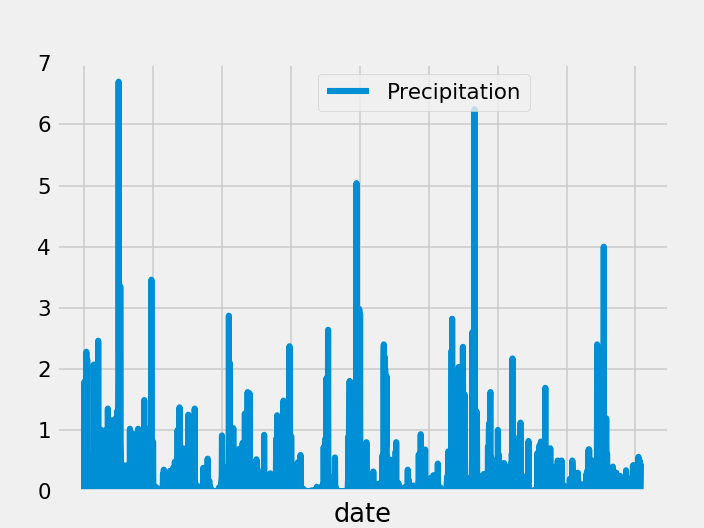

In [24]:
# Use Pandas Plotting with Matplotlib to plot the data

PrcpPlot = Prcp_df.plot()
plt.legend(bbox_to_anchor=(0.6, 1), loc='upper center', ncol=1)


PrcpPlot.set_ylim([0, 7])

# Rotate the xticks for the dates

plt.xticks(rotation=90)

#Save figure
plt.savefig('prcp.png')

#Show plot
plt.show()




In [12]:
#Use Pandas to calcualte the summary statistics for the precipitation data
Prcp_df.describe()


,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# How many stations are available in this dataset?


StationCount = session.query(func.count(distinct(Measurement.station))).scalar()
StationCount


9

In [14]:
# What are the most active stations?
# List the stations and the counts in descending order.
TobsCount = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).all()
TobsCount

[('USC00511918', 1979),
 ('USC00513117', 2709),
 ('USC00514830', 2202),
 ('USC00516128', 2612),
 ('USC00517948', 1372),
 ('USC00518838', 511),
 ('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00519523', 2669)]

In [15]:
#Sort resulting list of tuples in descending order by the second numeric value
TobsCountDesc = sorted(TobsCount,key=lambda x:(-x[1],x[0]))
TobsCountDesc

#Station with highest observations = USC00519281

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
#Highest temperature for most active station
TobsMax = session.query(func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281').scalar()
TobsMax


85.0

In [17]:
#Lowest temperature for most active station
TobsMin = session.query(func.min(Measurement.tobs)).filter(Measurement.station == 'USC00519281').scalar()
TobsMin

54.0

In [18]:
#Avg temperature for most active station
TobsAvg = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').scalar()
TobsAvg

71.66378066378067

In [19]:
# Choose the station with the highest number of temperature observations and retrieve the last 12 months of temperature observation data (tobs).
Last12_Tobs = session.query(Measurement.tobs, Measurement.date).filter(and_(Measurement.date >= query_date, Measurement.station == 'USC00519281')).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
Tobs_df = pd.DataFrame(Last12_Tobs)
Tobs_df = Tobs_df.set_index('date')

# Sort the dataframe by date
Tobs_df= Tobs_df.sort_values(by=['date']).dropna()
Tobs_df.columns = ['Tobs']



<IPython.core.display.Javascript object>


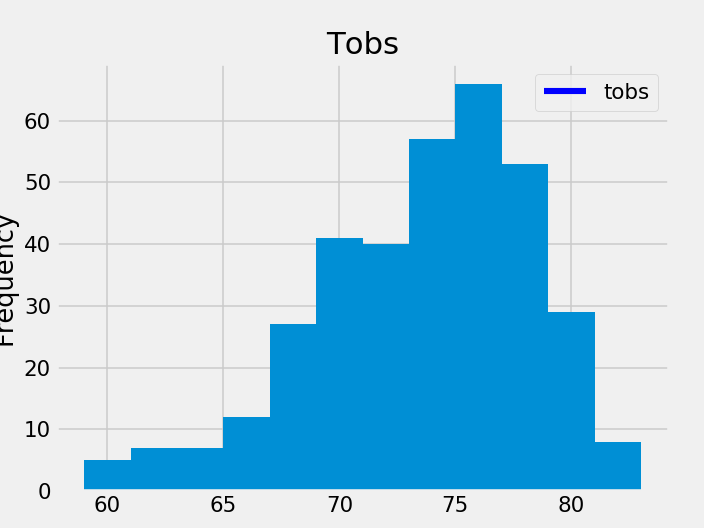

In [20]:
#Plot histogram with the above query results
Tobs_df.hist(bins=12)
plt.ylabel("Frequency")

# Create legend
blue_line = mlines.Line2D([], [], color='blue', label='tobs')
plt.legend(handles = [blue_line], bbox_to_anchor=(1, 1), loc='best', ncol=1)

#Save figure
plt.savefig('histogram.png')

#Show histogram
plt.show()


In [21]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
Trip = calc_temps('2016-08-23', '2016-08-30')
Trip






[(71.0, 78.11538461538461, 84.0)]

In [59]:

# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

In [23]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation







## Optional Challenge Assignment

In [58]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
